In [1]:
import stereo as st
import pandas as pd
import bokeh
import matplotlib.pyplot as plt

/opt/venv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# LISTA data (DY1_D0_stereo-seq.h5ad)

## Area

DY1_D0 represents $48.143 mm^2$

From the paper: each bin contains 50x50 nanoballs, so the h5ad bin size is incorrect.

Center-to-center distance of 715nm between nanoballs, aka bin-resolution of 36x36 um

Liver cells are larger, so this is probably capturing close to a single-cell diameter.

## Design

In total, 30 whole liver lobe sections

Time series (Day 0,1,2,3,7)

Matched scRNA-seq.

# Find anndata under 'adata'

In [2]:
h5ad = st.io.read_h5ad('../data/DY1_D0_stereo-seq.h5ad')

In [3]:
# anndata object is under adata
h5ad.adata

AnnData object with n_obs × n_vars = 37669 × 29075
    obs: 'annotation'
    uns: 'annotation_colors', 'sn'
    obsm: 'spatial'

In [4]:
h5ad.adata.X.shape

(37669, 29075)

In [5]:
h5ad.adata.var

""
0610005C13Rik
0610006L08Rik
0610009B22Rik
0610009O20Rik
0610010F05Rik
...
4930520M14Rik
Igkv1-88
Gm34811
Gm28487


In [6]:
h5ad.adata.obs

,annotation
DY1_D0_249_210,Layer 6
DY1_D0_147_141,Layer 1
DY1_D0_182_257,Layer 6
DY1_D0_130_258,Layer 6
DY1_D0_240_261,Layer 1
...,...
DY1_D0_276_174,Layer 3
DY1_D0_201_70,Layer 5
DY1_D0_154_260,Layer 3
DY1_D0_122_149,Layer 3


In [7]:
# These two ways of accessing the counts matrix are equivalent
h5ad.exp_matrix == h5ad.adata.X

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

In [8]:
# Here are the bin positions
h5ad.position

array([[249, 210],
       [147, 141],
       [182, 257],
       ...,
       [154, 260],
       [122, 149],
       [199,  70]])

In [9]:
# Bin size variable in here is not correct
h5ad.bin_size

1

In [10]:
# It's not clear to me what units the resolution here is in
# but presumably, this means the spot-to-spot distance in... micrometers?
h5ad.resolution

500

In [11]:
# Setting up a 1mm scalebar we can add to our plots

def add_scalebar(ax, spot_to_spot_distance = 0.5):

    from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar

    # spot_to_spot_distance = 0.5 # um
    scale_bar_size = 500 # um (1mm)
    length = scale_bar_size / spot_to_spot_distance

    scalebar = AnchoredSizeBar(ax.transData,
        scale_bar_size / spot_to_spot_distance, '500um', 'lower right', 
        pad=0.4,
        color='black',
        frameon=False,
        size_vertical=length / 6)
    
    ax.add_artist(scalebar)

In [12]:
h5ad.adata.shape

(37669, 29075)

In [13]:
h5ad.adata.shape[0] * h5ad.adata.shape[1] * 4

4380904700

In [14]:
# Get approx size in GB of this data to check that it makes sense
4380904700 / 1_000_000_000

4.3809047

## Visualize the summed expression

In [15]:
viz_data = pd.DataFrame(h5ad.position, columns=['X','Y'])
viz_data['counts'] = h5ad.exp_matrix.sum(axis=1)

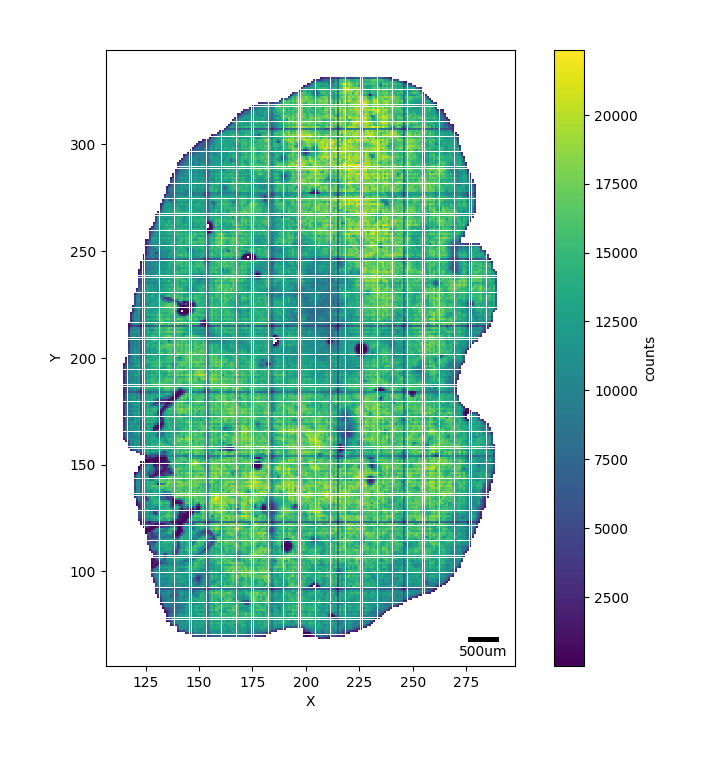

In [16]:
ax = viz_data \
    [lambda x: x.counts > 0] \
    .plot.scatter('X', 'Y', c='counts', s=2, cmap='viridis', marker='s')

# Despite what h5ad.bin_size indicates,
# This data is definitely binned.
# Going from the actual paper, it appears to be bin70 (go figure)
# i.e., 70 * 

add_scalebar(ax, spot_to_spot_distance=0.5*70)
ax.set_aspect('equal') # Keep aspect ratio fixed

plt.gcf().set_size_inches(10,8)

In [17]:
h5ad.adata.obsm.flipped()['spatial']

array([[249, 210],
       [147, 141],
       [182, 257],
       ...,
       [154, 260],
       [122, 149],
       [199,  70]])

In [18]:
h5ad.adata.uns['annotation_colors']

array(['#440154', '#472d7b', '#3b528b', '#2c728e', '#21918c', '#28ae80',
       '#5ec962', '#addc30', '#fde725'], dtype=object)

In [19]:
# This is the precalculated clusters
h5ad.adata.obs['annotation']

DY1_D0_249_210    Layer 6
DY1_D0_147_141    Layer 1
DY1_D0_182_257    Layer 6
DY1_D0_130_258    Layer 6
DY1_D0_240_261    Layer 1
                   ...   
DY1_D0_276_174    Layer 3
DY1_D0_201_70     Layer 5
DY1_D0_154_260    Layer 3
DY1_D0_122_149    Layer 3
DY1_D0_199_70     Layer 5
Name: annotation, Length: 37669, dtype: category
Categories (9, object): ['Layer 1', 'Layer 2', 'Layer 3', 'Layer 4', ..., 'Layer 6', 'Layer 7', 'Layer 8', 'Layer 9']